# Tutorial 3 – Sung Language Identification

As a last example, we turn our attention to **sung language identification** (SLID). The goal of this task is to estimate the most likely language being sung by a vocalist in a recording. 

Sung language ID is an interesting challenge for machine listening systems for two reasons. One, the ability to identify language is a first step on a path toward lyrics transcription, an even *more* complex task given the abstract and fluid role of language in music. Two, for being an "easier" task, _i.e._ one can recognize a language without understanding it, SLID is an immediately useful application of machine listening for global music streaming services.

In this notebook, we continue to build on concepts covered in the previous two notebooks to begin an exploration on modeling language in recorded music, organized as follows:

### Contents
0. [Getting the Data](#Getting-the-Data)
1. [Feature Extraction](#Feature-Extraction)
2. [Data Sampling](#Data-Sampling)
3. [A Job for Deep Learning](##A-Job-for-Deep-Learning)
4. [Evaluation](#Evaluation)
5. [Summary](#Summary)

In [1]:
# All libraries used in this notebook
import collections, glob, itertools
import keras, librosa, mir_eval, os, pescador, sklearn, tqdm

from IPython.display import Audio, HTML, display
from joblib import Parallel, delayed
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import soundfile as sf

%matplotlib inline

Using TensorFlow backend.


## Getting the Data

For this example, we use a collection of content sampled from the Creative Commons service Jamendo. You can find and download the [dataset online](https://zenodo.org/record/2533051). 

The dataset contains 700 audio recordings (around 6GB of data) from unique artists, _i.e._ 700 artists, 100 drawn from six languages each: german (de), english (en), french (fr), italian (it), spanish (es), and russian (ru), and another 100 instrumental (non-vocal) tracks. 

When expanded, the TGZ archive hosted on Zenodo contains a folder of OGG files (`./audio`) and a CSV file of metadata (`dataset.csv`). The audio files are named with the convention `{track_id}`, where `track_id` corresponds to the first column in `dataset.csv`, serving as the primary key in the metadata table. In addition to `track_language`, this CSV file contains all provenance and licensing information for this content. For our purposes, we'll focus on these first two columns here.

In [2]:
# Update `DATA_ROOT` to match the expanded location of the dataset.
DATA_ROOT = '/Users/ejhumphrey/data/jamendo-slid-700/'
AUDIO = os.path.join(DATA_ROOT, 'audio')

# We'll write feature data here
FEATURES = os.path.join(DATA_ROOT, 'features')

if not os.path.exists(FEATURES):
    os.makedirs(FEATURES)

### Examining the metadata table

First, let's take a look at the metadata CSV file. We'll load it into memory as a Panda's `DataFrame`, which provides a powerful interface over tabular, mixed datatype information.

In [3]:
df = pd.read_csv(os.path.join(DATA_ROOT, 'dataset.csv'), index_col=0)
df.sample(n=5)

track_language  album_id  \
track_id                            
1312860              es    155876   
1282291    instrumental    152936   
1085878              it    129424   
604658               es     69899   
961138               it    112968   

                                                album_image  \
track_id                                                      
1312860   https://imgjam1.jamendo.com/albums/s155/155876...   
1282291   https://imgjam2.jamendo.com/albums/s152/152936...   
1085878   https://imgjam1.jamendo.com/albums/s129/129424...   
604658    https://imgjam2.jamendo.com/albums/s69/69899/c...   
961138    https://imgjam2.jamendo.com/albums/s112/112968...   

                  album_name  artist_id      artist_idstr       artist_name  \
track_id                                                                      
1312860             Ambición     486972         MOAVE_(2)             MOAVE   
1282291     Feeling Positive     483163             alumo             alumo   
1085878        Siamo la rete     360980  Trenini_Acustici  Trenini Acustici   
604658    Mi Defecto Anonimo     337988      Icarus_Crash      Icarus Crash   
961138      Orizzonti Sonori     358070  Enrico_Antonazzo  Enrico Antonazzo   

                                                      audio  \
track_id                                                      
1312860   https://mp3l.jamendo.com/?trackid=1312860&form...   
1282291   https://mp3l.jamendo.com/?trackid=1282291&form...   
1085878   https://mp3l.jamendo.com/?trackid=1085878&form...   
604658    https://mp3l.jamendo.com/?trackid=604658&forma...   
961138    https://mp3l.jamendo.com/?trackid=961138&forma...   

                                              audiodownload  duration  \
track_id                                                                
1312860   https://ogg.jamendo.com/download/track/1312860...       194   
1282291   https://flac.jamendo.com/download/track/128229...       117   
1085878   https://ogg.jamendo.com/download/track/1085878...       215   
604658    https://ogg.jamendo.com/download/track/604658/...       209   
961138    https://ogg.jamendo.com/download/track/961138/...       266   

                                                      image  \
track_id                                                      
1312860   https://imgjam1.jamendo.com/albums/s155/155876...   
1282291   https://imgjam2.jamendo.com/albums/s152/152936...   
1085878   https://imgjam1.jamendo.com/albums/s129/129424...   
604658    https://imgjam2.jamendo.com/albums/s69/69899/c...   
961138    https://imgjam2.jamendo.com/albums/s112/112968...   

                                              license_ccurl  position  \
track_id                                                                
1312860   http://creativecommons.org/licenses/by-nc-nd/3.0/         3   
1282291   http://creativecommons.org/licenses/by-nc-nd/3.0/         6   
1085878   http://creativecommons.org/licenses/by-nc-sa/3.0/         1   
604658    http://creativecommons.org/licenses/by-nc-sa/3.0/         1   
961138    http://creativecommons.org/licenses/by-sa/2.5/it/         2   

         releasedate                              shareurl  \
track_id                                                     
1312860   2016-01-28  http://www.jamendo.com/track/1312860   
1282291   2015-10-15  http://www.jamendo.com/track/1282291   
1085878   2013-12-09  http://www.jamendo.com/track/1085878   
604658    2010-06-26   http://www.jamendo.com/track/604658   
961138    2012-08-26   http://www.jamendo.com/track/961138   

                           shorturl       track_name  
track_id                                              
1312860   http://jamen.do/t/1312860        Tan Cerca  
1282291   http://jamen.do/t/1282291  A Wonderful Day  
1085878   http://jamen.do/t/1085878    Siamo la rete  
604658     http://jamen.do/t/604658       Filamentos  
961138     http://jamen.do/t/961138   Ombre nel sole

## Feature Extraction

We'll reuse the feature extraction approach from before to compute MFCC features over the collection of audio. 

The features are written to disk under the same track ID as the audio file, and so we can join the feature object on the table later.

In [4]:
def compute_features(af, n_fft, hop_length, n_mfcc, skip_existing=True):
    filebase = os.path.splitext(os.path.basename(af))[0]
    output_file = os.path.join(FEATURES, '{}.npz'.format(filebase))
    if os.path.exists(output_file) and skip_existing:
        return
        
    y, sr = sf.read(af)
    if y.ndim == 2:
        y = y.mean(axis=1)
    
    # Transpose to be time-major (rows)
    X = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, 
                             n_fft=n_fft, hop_length=hop_length).T

    time = librosa.frames_to_time(frames=np.arange(len(X)), 
                                  hop_length=hop_length, n_fft=n_fft, sr=sr)
    
    np.savez(output_file, mfcc=X, time=time)

In [5]:
# Compute MFCCs and write to disk. 
# Using three cores on a MacBook Air, takes ≈10min
hop_length = 512
n_fft = 1024
n_mfcc = 20

audio_files = glob.glob(os.path.join(AUDIO, '*.ogg'))

dfx = delayed(compute_features)
pool = Parallel(n_jobs=-1, verbose=1)
pool(dfx(af, n_fft, hop_length, n_mfcc) for af in audio_files)

# When we're done, pick up the audio and feature files,
# and "align" them, e.g. audio_files[0] corresponds to feature_files[0], etc
audio_files, feature_files = mir_eval.util.intersect_files(
    audio_files, glob.glob(os.path.join(FEATURES, '*npz')))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished


## Data Sampling

First, we have to partition the dataset for training and test. We can do this by grouping on track language, shuffling (with `sample`), and slicing 90 for training / 10 for test. 

In [6]:
# Map the different track language codes to integer indexes
LABEL_MAP = {'de': 0, 'en': 1, 'es': 2, 'fr': 3, 
             'it': 4, 'ru': 5, 'instrumental': 6}
num_classes = len(LABEL_MAP)

In [7]:
train_ratio = 0.9
rng = np.random.RandomState(12345)
train_rows, test_rows = [], []
for track_language in LABEL_MAP:
    rows = df[df.track_language == track_language]
    # Shuffle the tracks
    rows = rows.sample(frac=1, random_state=rng)
    
    num_train = int(train_ratio * len(rows))
    train_rows += [rows[:num_train]]
    test_rows += [rows[num_train:]]

df_train = pd.concat(train_rows)
df_test = pd.concat(test_rows)

In [8]:
df_train.shape, df_test.shape

((630, 17), (70, 17))

### Sample Generator

Here we define a generator for sampling observations from a feature file. 

First, we will create a sampler from each `row` in the metadata DataFrame. Iterating over rows in a `DataFrame` produces a `Series` object, which allows for dot-accessor methods on column attributes.

Second, we're using fully mixed music in this collection, not isolated recordings of singing like in Tutorial 2 (Vocalist ID). While it would be great to limit our focus to parts of the recording that *actually* contain voice, we don't (yet!) know *exactly* when that occurs. As a result, we'll occasionally draw samples that don't contain any voice, which will introduce some amount of label noise into the modeling task.

Note though, that all recordings contain *some* voice (except the instrumental tracks, clearly), and so track-level evaluation should be stable.

In [9]:
def sampler(row, num_frames, random_state=None):
    npz_file = os.path.join(FEATURES, '{}.npz'.format(row.name))
    with np.load(npz_file) as data:
        mfcc = np.array(data['mfcc'])
        time = np.array(data['time'])
    
    # Build an index for centered observations
    idx = np.arange(len(mfcc))[num_frames // 2: -num_frames // 2]
    
    # Create a random state object and shuffle the index
    rng = np.random.RandomState(random_state)
    rng.shuffle(idx)
    counter = 0

    while True:
        i0 = idx[counter] - num_frames // 2
        i1 = i0 + num_frames
        # Force the array-copy to avoid memory leaks!
        yield dict(x=np.array(mfcc[i0:i1, :]), 
                   y=LABEL_MAP[row.track_language], 
                   k='{}_{}'.format(row.name, i0))

        counter += 1
        if counter == len(idx):
            counter = 0
            rng.shuffle(idx)

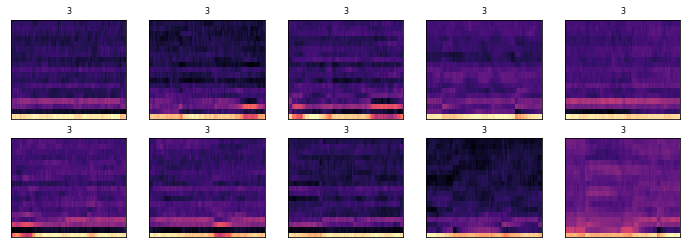

In [10]:
# Retrieve the samplerate for the display function.
SR = sf.info(audio_files[0]).samplerate

gen = sampler(df_train.sample(n=1).iloc[0], 80)
fig, axes = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)

for ax, sample in zip(axes.flatten(), gen):
    librosa.display.specshow(sample['x'].T[1:], sr=SR, hop_length=hop_length, 
                             x_axis='off', y_axis='off', ax=ax, cmap='magma')
    ax.set_title(sample['y'], fontsize=8)

### Sampling indefinitely for training

In previous examples, we collected a fixed number of datapoints to use for fitting a model. Here, we demonstrate how to build an indefinite data stream over a collection of feature objects for training. 

The motivation here is two-fold: one, in practice, you will likely find yourself tackling problems where your dataset doesn't fit in memory, and it can be handy to use the same implementation in development as production. Two, sampling parameters, e.g. window length, filtering, etc, may be important or interesting parameters in your experimental framework, and building data samplers in this manner simplifies the process of exploring them.

In [11]:
num_frames = 512  # corresponds to approx 6 seconds

train_stream = pescador.ShuffledMux(
    [pescador.Streamer(sampler, row, num_frames) for (_, row) in df_train.iterrows()])

train_batches = pescador.Streamer(pescador.buffer_stream, train_stream, buffer_size=16)

In [12]:
sample_batch = next(train_batches.iterate(max_iter=1))
sample_batch['x'].shape, sample_batch['y'].shape

((16, 512, 20), (16,))

In contrast to training, we'll sample a fixed holdout set for testing purposes. Online streams, like those above, can be used for validation, but more clever approaches are necessary to account for variance across random samples of the data.

In [13]:
test_stream = pescador.ShuffledMux(
    [pescador.Streamer(sampler, row, num_frames) 
     for (_, row) in df_test.iterrows()])

X_test, Y_test, keys = [], [], []
for sample in tqdm.tqdm_notebook(test_stream.cycle(max_iter=10000)):
    X_test += [sample['x']]
    Y_test += [sample['y']]
    keys += [sample['k']]

X_test, Y_test = np.array(X_test), np.array(Y_test)

## A Job for Deep Learning

Whereas the previous examples first considered simpler baselines, we can directly consdier a deep network here. Experimental comparison against alternative models, e.g. Random Forest, would be necessary for a proper scientific study, but we leave this as an exercise.

The following network, while still on the simpler side, is starting to look more like a "real" deep neural network. The following is a five-layer network, which stacks two convolutional layers, a recurrent LSTM layer, and two dense (fully-connected) layers, the last of which acts as a multinomial estimator. Batch normalization is used in the time-dependent layers to facilitate learning.

In [13]:
x_in = keras.layers.InputLayer(input_shape=(num_frames, n_mfcc))

bn0 = keras.layers.BatchNormalization(axis=-1, scale=True)
layer0 = keras.layers.Conv1D(filters=16, kernel_size=5, 
                             padding='valid', activation='relu')
pool0 = keras.layers.MaxPool1D(pool_size=4)

bn1 = keras.layers.BatchNormalization(axis=-1, scale=True)
layer1 = keras.layers.Conv1D(filters=24, kernel_size=5,
                             padding='valid', activation='relu')
pool1 = keras.layers.MaxPool1D(pool_size=4)

bn2 = keras.layers.BatchNormalization(axis=-1, scale=True)
layer2 = keras.layers.Conv1D(filters=32, kernel_size=5,
                             padding='valid', activation='relu')
pool2 = keras.layers.GlobalAvgPool1D()

layer3 = keras.layers.Dense(64, activation='relu')
drop3 = keras.layers.Dropout(0.5)

layer4 = keras.layers.Dense(num_classes, activation='softmax')
dnn = keras.Sequential([x_in, bn0, layer0, pool0, bn1, layer1, pool1, 
                        bn2, layer2, pool2, layer3, drop3, layer4])

dnn.compile(keras.optimizers.Adam(lr=0.0001, beta_1=0.5), 
            'sparse_categorical_crossentropy', metrics=['accuracy'])
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 512, 20)           80        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 508, 16)           1616      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 127, 16)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 127, 16)           64        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 123, 24)           1944      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 30, 24)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 24)            96        
__________

We let it train here for ≈10min. You could (and probably need to) let this go on for hours (or more!), but we want to see that the model has learned *something* slightly better than random after a few thousand iterations. 

In [14]:
history = dnn.fit_generator(pescador.tuples(train_batches.cycle(), 'x', 'y'), 
                            validation_data=(X_test, Y_test),
                            steps_per_epoch=2500, epochs=10)

Epoch 1/10
2500/2500 [==============================] - 71s 28ms/step - loss: 1.8848 - acc: 0.2274 - val_loss: 1.8896 - val_acc: 0.2359
Epoch 2/10
2500/2500 [==============================] - 51s 20ms/step - loss: 1.7983 - acc: 0.2809 - val_loss: 1.8561 - val_acc: 0.2765
Epoch 3/10
2500/2500 [==============================] - 51s 20ms/step - loss: 1.7491 - acc: 0.3097 - val_loss: 1.8523 - val_acc: 0.2812
Epoch 4/10
2500/2500 [==============================] - 52s 21ms/step - loss: 1.7201 - acc: 0.3207 - val_loss: 1.8383 - val_acc: 0.2938
Epoch 5/10
2500/2500 [==============================] - 53s 21ms/step - loss: 1.6797 - acc: 0.3425 - val_loss: 1.8718 - val_acc: 0.2987
Epoch 6/10
2500/2500 [==============================] - 52s 21ms/step - loss: 1.6639 - acc: 0.3508 - val_loss: 1.8603 - val_acc: 0.3133
Epoch 7/10
2500/2500 [==============================] - 52s 21ms/step - loss: 1.6354 - acc: 0.3603 - val_loss: 1.8668 - val_acc: 0.3228
Epoch 8/10
2500/2500 [==========================

In [15]:
Y_proba = dnn.predict(X_test)

In [16]:
Y_pred = Y_proba.argmax(axis=1)
print(sklearn.metrics.classification_report(Y_test, Y_pred, 
                                            target_names=LABEL_MAP.keys()))

              precision    recall  f1-score   support

          de       0.33      0.21      0.26      1498
          en       0.38      0.51      0.43      1452
          es       0.29      0.23      0.26      1389
          fr       0.27      0.24      0.25      1399
          it       0.22      0.19      0.20      1498
          ru       0.26      0.24      0.25      1377
instrumental       0.37      0.58      0.45      1387

   micro avg       0.31      0.31      0.31     10000
   macro avg       0.30      0.31      0.30     10000
weighted avg       0.30      0.31      0.30     10000



We can see from this quick benchmark that the model's doing a fair bit better than random (a uniformly random class predictor would produce $1/7 ≈ 14\%$), which is promising! That said, the accuracy we're getting after several thousand iterations isn't great either. 

To begin to understand what the model may have learned, let's see what a time-varying estimation looks like over the duration of an entire recording. Again, we'll apply the model as a strided convolution. This time, however, let's examine a track in the *training* set to see how well the model is fitting the data in the first place.

In machine learning, it can be a helpful debugging practice to attempt to understand when (and why) a model is unable to fit the training data. This may be due to noise in the labels, limited representational power of the model, or perhaps something more specific to the problem setup.

In [17]:
# Pick a random test track
row = df_train.sample(n=1).iloc[0]

npz_file = os.path.join(FEATURES, '{}.npz'.format(row.name))
with np.load(npz_file) as data:
    mfcc = np.pad(data['mfcc'], ((num_frames, 0), (0, 0)), 'edge') 
    time = np.array(data['time']) 

# Convolve the model over the full feature sequence.
Y_pred = dnn.predict(np.array([mfcc[n:n + num_frames] 
                               for n in range(len(time))])).squeeze()

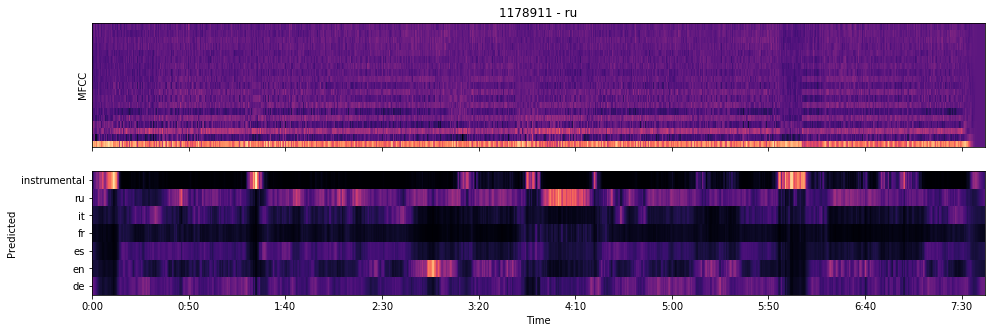

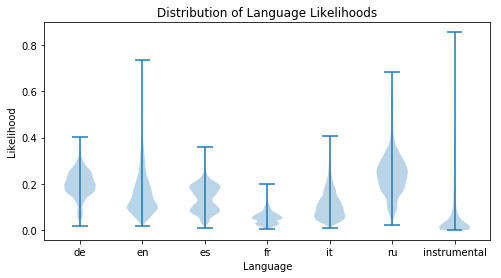

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(16, 5), sharex=True)

# Drop the first coefficient (amplitude) for visualization
audio_file = os.path.join(AUDIO, '{}.ogg'.format(row.name))
x, sr = sf.read(audio_file)
librosa.display.specshow(mfcc[num_frames:, 1:].T, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='off', ax=axes[0], cmap='magma')
axes[0].set_ylabel("MFCC")
axes[1].imshow(Y_pred.T, extent=[0, time.max(), 0, num_classes], 
               aspect='auto', interpolation='nearest', 
               origin='lower', cmap='magma')
axes[1].set_ylabel("Predicted")
axes[1].set_yticks(np.arange(num_classes) + 0.5)
axes[1].set_yticklabels(LABEL_MAP.keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.violinplot(Y_pred)
ax.set_xticks(np.arange(num_classes) + 1)
ax.set_xticklabels(LABEL_MAP.keys())
ax.set_title('Distribution of Language Likelihoods')
ax.set_ylabel('Likelihood')
ax.set_xlabel('Language')

# Display tweaks
for ax, xlabel, title in zip(axes, ['', 'Time'], 
                             ['{} - {}'.format(row.name, row.track_language), '']):
    ax.set_xlabel(xlabel)
    ax.set_title(title)

display(Audio(filename=audio_file))

By looking at the time-varying estimations, we can see that the estimated classes vary over time, and bounce between different languages within the same track. We can conclude that the model has yet to really learn the right acoustic attributes about the different languages. One exception to this, however, is that the model is implicitly learning vocal activity from the instrumental tracks.

In other words, there's far more work to be done here to build good acoustic models for identifying sung language in music. We offer a few ideas below, but hope that this setup can point you in the right direction toward developing a more performant, and perhaps publishable, result.


After all, you didn't think they would all be *easy*, did you? 

## Summary

In this final tutorial, we've begun exploring the task of sung language identification using a deep neural network. Here we've built a sample generator over our training dataset, trained a model, and looked at model performance a few ways.

* Extracted MFCC features
* Defined sample generators that yield windowed observations with labels from the data
* Sampled a test set to evaluate our models
* Designed a convolutional neural network model
* Trained our deep network with a training data generator 
* Computed accuracy / error over the test
* Visualized how language estimate varies over time

## Where to go next?

Language identification in mixed, polyphonic music is certainly the most difficult of the three tasks explored here, and it will take some effort to produce a model with better accuracy. Here we list a few paths for subsequent work, but this is by no means exhaustive.


### 1. Different Features, Model Variations, Training Tricks...

In the previous tutorials, we've mentioned a number of possible opportunities for future exploration, and they are all equally valid here, if not more so. For starters, the model described here could be trained for many more iterations. This might warrant hardware acceleration or better computational resources than available on the machine you're currently using. As a rule of thumb, you should generally be able to fit your training data to a large degree. Less processed features or more complex models should lead to an increase in the ability to at least achieve high accuracy on the training set, a sign we can at least fit the data. 


### 2. Pre-process with other Vocal Systems
 
In an earlier example, we learned how to train a vocal activity detection model - now, we could take that model and use it to pre-process this collection for sung language ID, so that we could filter out parts of songs that probably don't contain voice. Alternatively, source separation would help eliminate background sounds which may have a confounding influence, as well as help isolate where vocals occur in the recording.


### 3. Model Attention in Multiple Instance Learning

This particular formulation, where an unknown subset of observations drawn from a collection that have some property, is known as **multiple instance learning**. We know that only some of the observations drawn from a recording correspond to the annotated track language, whereas the rest should be labeled as "no vocals" or "no discernable language", e.g. sustained vowels like ooh's and aah's. One way to tackle this kind of problem is to model "attention", where a system learns to weight the contributions of its inputs based on what information is helpful to the given task. This has been an active area of research in machine learning, and would no doubt prove helpful here.


### 4. Find more training data

Given the challenging nature of this task, it's likely that more training data will (eventually) be valuable. There are a few ways to go about getting more data for training:

* Assume that an artist only performs in one language, and we could backfill with more data from Jamendo. 
* Use a text-based classifier to estimate the track language from the track title
* Use a weak model on a large collection of data, and introduce manual correction / verification via **active learning** 